# Data acquisition and Basic Descriptions

In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
# import squarify    # pip install squarify (algorithm for treemap)
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTETomek

sb.set() 

In [2]:
# !pip install squarify
# !pip install imblearn

In [3]:
#Import the dataset
url = 'https://raw.githubusercontent.com/zzzhimin/DSAI-Mini-Project/master/AviationData.csv'
baseData = pd.read_csv(url,encoding = "ISO-8859-1")

In [4]:
baseData.shape

(84262, 31)

In [5]:
baseData.dtypes

Event.Id                   object
Investigation.Type         object
Accident.Number            object
Event.Date                 object
Location                   object
Country                    object
Latitude                  float64
Longitude                 float64
Airport.Code               object
Airport.Name               object
Injury.Severity            object
Aircraft.Damage            object
Aircraft.Category          object
Registration.Number        object
Make                       object
Model                      object
Amateur.Built              object
Number.of.Engines         float64
Engine.Type                object
FAR.Description            object
Schedule                   object
Purpose.of.Flight          object
Air.Carrier                object
Total.Fatal.Injuries      float64
Total.Serious.Injuries    float64
Total.Minor.Injuries      float64
Total.Uninjured           float64
Weather.Condition          object
Broad.Phase.of.Flight      object
Report.Status 

In [6]:
baseData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84262 entries, 0 to 84261
Data columns (total 31 columns):
Event.Id                  84262 non-null object
Investigation.Type        84257 non-null object
Accident.Number           84262 non-null object
Event.Date                84262 non-null object
Location                  84185 non-null object
Country                   83755 non-null object
Latitude                  30163 non-null float64
Longitude                 30154 non-null float64
Airport.Code              47723 non-null object
Airport.Name              50439 non-null object
Injury.Severity           84262 non-null object
Aircraft.Damage           81553 non-null object
Aircraft.Category         27508 non-null object
Registration.Number       80412 non-null object
Make                      84192 non-null object
Model                     84163 non-null object
Amateur.Built             83653 non-null object
Number.of.Engines         79228 non-null float64
Engine.Type             

In [7]:
baseData.describe() #Description of numeric data

,Latitude,Longitude,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,30163.000000,30154.000000,79228.000000,57059.000000,54384.000000,55592.000000,69673.000000
mean,37.544907,-93.508337,1.146930,0.847614,0.331715,0.518708,5.901325
std,12.370282,39.454412,0.447004,6.292468,1.375602,2.771339,29.534302
min,-78.016945,-178.676111,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.307778,-114.861042,1.000000,0.000000,0.000000,0.000000,0.000000
50%,38.125278,-94.371667,1.000000,0.000000,0.000000,0.000000,1.000000
75%,42.524723,-81.650278,1.000000,1.000000,0.000000,1.000000,2.000000
max,89.218056,179.618611,8.000000,349.000000,111.000000,380.000000,699.000000


In [8]:
#description of non numeric data
for i in baseData:
    if baseData[i].dtypes != 'float64':
        print(baseData[i].describe(), '\n\n')

count              84262
unique             83035
top       20001212X19172
freq                   3
Name: Event.Id, dtype: object 


count        84257
unique           2
top       Accident
freq         80814
Name: Investigation.Type, dtype: object 


count          84262
unique         84262
top       ANC14WA019
freq               1
Name: Accident.Number, dtype: object 


count          84262
unique         13718
top       2000-07-08
freq              25
Name: Event.Date, dtype: object 


count             84185
unique            26575
top       ANCHORAGE, AK
freq                372
Name: Location, dtype: object 


count             83755
unique              179
top       United States
freq              78849
Name: Country, dtype: object 


count     47723
unique    10019
top        NONE
freq       1473
Name: Airport.Code, dtype: object 


count       50439
unique      23863
top       PRIVATE
freq          217
Name: Airport.Name, dtype: object 


count         84262
unique          12

# Extraction and Data Cleanup

In [9]:
aviationData = pd.DataFrame(baseData[['Latitude', 'Longitude', 'Injury.Severity', 'Aircraft.Damage', 'Aircraft.Category', 'Number.of.Engines', 'Engine.Type', 'Purpose.of.Flight', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Weather.Condition', 'Broad.Phase.of.Flight', 'Amateur.Built', 'FAR.Description']])

In [10]:
for i in aviationData:
    if(aviationData[i].dtypes != 'float64' and aviationData[i].dtypes != 'int64'):
        aviationData[i] = aviationData[i].str.upper()

In [11]:
#Removing ameteur built planes
aviationData = aviationData[aviationData['Amateur.Built'] == 'NO']

In [12]:
aviationData = aviationData.drop(['Amateur.Built'], axis = 1)

In [13]:
#New column for total passengers
aviationData['Total.Passengers'] = 0

In [14]:
#Filling up NaN values with 0 for empty passenger counts
for i in aviationData:
    if(i == 'Number.of.Engines'):
        continue
        
    if(aviationData[i].dtypes == 'float64' and i != 'Latitude' and i != 'Longitude'):
        aviationData[i] = aviationData[i].fillna(0)

In [15]:
#Finding missing airplane data by using passenger count as an estimate
for index, row in aviationData.iterrows():
    totalPassengers = aviationData.at[index, 'Total.Fatal.Injuries'] + aviationData.at[index, 'Total.Serious.Injuries'] + aviationData.at[index, 'Total.Minor.Injuries'] + aviationData.at[index, 'Total.Uninjured']
    if(totalPassengers > 30):
        aviationData.at[index, 'Aircraft.Category'] = 'AIRPLANE'
    aviationData.at[index, 'Total.Passengers'] = totalPassengers

In [16]:
#Removing non-airplane data
aviationData = aviationData[aviationData['Aircraft.Category'] == 'AIRPLANE']

In [17]:
#Removing aircrafts that have a purpose irrelevant to the problem
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'FIREFIGHTING']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'GLIDER TOW']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AIR DROP']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'SKYDIVING']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'INSTRUCTIONAL']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'BANNER TOW']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AERIAL OBSERVATION']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AIR RACE/SHOW']
aviationData = aviationData[aviationData['Purpose.of.Flight'] != 'AERIAL APPLICATION']

In [18]:
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Purpose.of.Flight'] == 'PUBLIC AIRCRAFT - STATE' or aviationData.at[index, 'Purpose.of.Flight'] == 'PUBLIC AIRCRAFT - FEDERAL' or aviationData.at[index, 'Purpose.of.Flight'] == 'PUBLIC AIRCRAFT - LOCAL'):
        aviationData.at[index, 'Purpose.of.Flight'] = 'PUBLIC AIRCRAFT'

In [19]:
#Dropping rows with incomplete flight state info
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Broad.Phase.of.Flight'] == 'UNKNOWN'):
        aviationData = aviationData.drop(index)
    
aviationData = aviationData.dropna(axis=0, subset=['Broad.Phase.of.Flight'])

In [20]:
#Removing rows with incomplete location data
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index, 'Latitude'])):
        aviationData.at[index, 'Latitude'] = aviationData['Latitude'].mean()
        
    if(pd.isnull(aviationData.at[index, 'Longitude'])):
        aviationData.at[index, 'Longitude'] = aviationData['Longitude'].mean()

In [21]:
#Dropping rows with incomplete passenger data
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Total.Passengers'] == 0):
        aviationData = aviationData.drop(index)

In [22]:
#Removing airplane data with incomplete passenger counts
aviationData = aviationData.drop(['Aircraft.Category'], axis = 1)

In [23]:
#Filling in missing engine type data
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index,'Engine.Type'])):
            aviationData.at[index, 'Engine.Type'] = 'UNKNOWN'

In [24]:
for index, row in aviationData.iterrows():
    if(row['Injury.Severity'] != 'NON-FATAL' and row['Injury.Severity'] != 'INCIDENT'):
        aviationData.at[index, 'Injury.Severity'] = 'FATAL'
        
for index, row in aviationData.iterrows():
    if(row['Number.of.Engines'] == 0):
        aviationData.at[index, 'Number.of.Engines'] = 4

In [25]:
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index,'Purpose.of.Flight'])):
        aviationData.at[index, 'Purpose.of.Flight'] = 'UNKNOWN'

In [26]:
#Filling in missing damage data
for index, row in aviationData.iterrows():
    if(pd.isnull(aviationData.at[index,'Aircraft.Damage'])):
        if(aviationData.at[index,'Broad.Phase.of.Flight'] == 'LANDING' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'CRUISE' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'MANEUVERING' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'LANDING'):
            aviationData.at[index, 'Aircraft.Damage'] = 'DESTROYED'
        elif(aviationData.at[index,'Broad.Phase.of.Flight'] == 'GO-AROUND' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'STANDING' or aviationData.at[index,'Broad.Phase.of.Flight'] == 'TAXI' or aviationData.at[index, 'Aircraft.Damage'] == 'CLIMB'):
            aviationData.at[index, 'Aircraft.Damage'] = 'MINOR'
        else:
            aviationData.at[index, 'Aircraft.Damage'] = 'SUBSTANTIAL'

In [27]:
aviationData = aviationData[aviationData['FAR.Description'].notna()]

In [28]:
for index, row in aviationData.iterrows():
    if(pd.isnull(row['Number.of.Engines'])):
        aviationData.at[index, 'Number.of.Engines'] = 4

In [29]:
#Removing flights that are irrelevant to the problem
aviationData = aviationData[aviationData['FAR.Description'] != 'ARMED FORCES']
aviationData = aviationData[aviationData['FAR.Description'] != 'PAR 91 SUBPART K: FRACTIONAL']
aviationData = aviationData[aviationData['FAR.Description'] != 'PART 137: AGRICULTURAL']
aviationData = aviationData[aviationData['FAR.Description'] != 'PART 125: 20+ PAX 6000+ LBS']

In [30]:
#Removing engine types that do not match transportation aircrafts
aviationData = aviationData[aviationData['Engine.Type'] != 'TURBO SHAFT']
aviationData = aviationData[aviationData['Engine.Type'] != 'ELECTRIC']
aviationData = aviationData[aviationData['Engine.Type'] != 'REC, TJ, TJ']

In [31]:
aviationData = aviationData[aviationData['Broad.Phase.of.Flight'] != 'OTHER']

In [32]:
aviationData = aviationData.drop(['FAR.Description'], axis = 1)

In [33]:
#Ensuring injury severity matches fatality data
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Injury.Severity'] == 'FATAL'):
        if(aviationData.at[index, 'Total.Fatal.Injuries'] == 0):
            aviationData.drop(index)
    else:
        if(aviationData.at[index, 'Total.Fatal.Injuries'] > 0):
            aviationData.drop(index)

In [34]:
#Converting whole number data to integer
for i in aviationData:
    if(aviationData[i].dtypes == 'float64' and i != 'Latitude' and i != 'Longitude'):
        aviationData[i] = aviationData[i].astype('int64')

In [35]:
#Reinitializing the index values for the rows to make them ordered and sequential
aviationData.index = range(len(aviationData))

In [36]:
#Using the given data in the dataset to determine the approximate altitude of the airplane during the accident

import requests
import urllib

# USGS Elevation Point Query Service
url = r'https://nationalmap.gov/epqs/pqs.php?'

# create data frame
df = pd.DataFrame({
    'lat': aviationData['Latitude'][:1],
    'lon': aviationData['Longitude'][:1]
})

def elevation_function(df, lat_column, lon_column):
    """Query service using lat, lon. add the elevation values as a new column."""
    elevations = []
    for lat, lon in zip(df[lat_column], df[lon_column]):

        # define rest query params
        params = {
            'output': 'json',
            'x': lon,
            'y': lat,
            'units': 'Meters'
        }

        # format query string and return query value
        result = requests.get((url + urllib.parse.urlencode(params)))
        elevations.append(result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])

    df['elev_meters'] = elevations

elevation_function(df, 'lat', 'lon')
df.head()

,lat,lon,elev_meters
0,39.128611,-123.715833,40.24


# Estimating the altitude of the Airplane

In [37]:
#The previous code to estimate retrieve elevation takes too long to execute for a large number of records. 
#Hence we have retrieved it once and pasted it in the existing csv file to avoid any overheads, and then imported the file again in this program.
#Besides the addition of elevation, the contents are exactly the same.
aviationData = pd.read_csv('Intermediate.csv')

In [38]:
#Using the data in our dataset and added elevation data to predict aircraft altitude
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Broad.Phase.of.Flight'] == 'CRUISE' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'MANEUVERING' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'GO-AROUND'):
        if(aviationData.at[index, 'Purpose.of.Flight'] == 'PERSONAL'):
            altitude = 12496.8 - aviationData.at[index, 'Altitude']
            if(altitude > 0):
                aviationData.at[index, 'Altitude'] = altitude
        else:
            altitude = 10972 - aviationData.at[index, 'Altitude']
            if(altitude > 0):
                aviationData.at[index, 'Altitude'] = altitude
    
    if(aviationData.at[index, 'Broad.Phase.of.Flight'] == 'APPROACH' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'DESCENT' or aviationData.at[index, 'Broad.Phase.of.Flight'] == 'CLIMB'):
        altitude = 700 - aviationData.at[index, 'Altitude']
        if(altitude > 0):
            aviationData.at[index, 'Altitude'] = altitude

In [39]:
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13005,10604.8,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,FERRY,0,0,0,1,VMC,CRUISE,1
13006,332.8,39.164723,-96.610412,INCIDENT,MINOR,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,APPROACH,1
13007,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,FERRY,0,0,0,1,VMC,TAKEOFF,1
13008,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,TAXI,1


In [40]:
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Weather.Condition'] == 'UNK'):
        aviationData.at[index, 'Weather.Condition'] = np.nan

In [41]:
for index, row in aviationData.iterrows():
    if(aviationData.at[index, 'Altitude'] < 0):
        aviationData.at[index, 'Altitude'] = 0

# Predicting Missing Weather data using AdaBoost

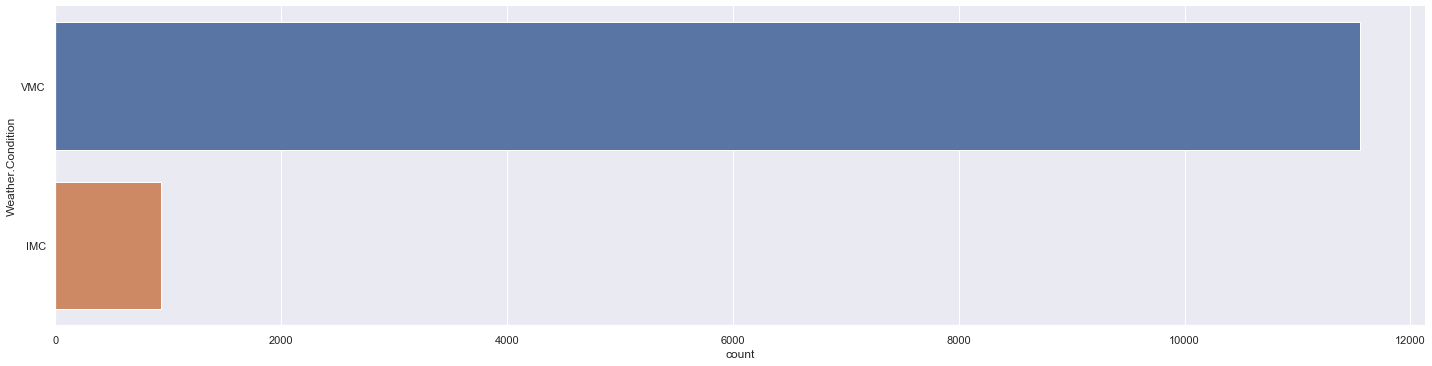

In [42]:
sb.catplot(y = 'Weather.Condition', data = aviationData, kind = "count", height = 5, aspect = 4)

In [43]:
finaltest = pd.DataFrame(aviationData[aviationData['Weather.Condition'].isnull()])
training = pd.DataFrame(aviationData[aviationData['Weather.Condition'].notnull()])

In [44]:
y = pd.DataFrame(training["Weather.Condition"])
X = pd.DataFrame(training[["Total.Fatal.Injuries", "Total.Serious.Injuries","Total.Minor.Injuries","Total.Uninjured","Total.Passengers"]])
# remap weather condition, IMC = true, VMC = false
for index, row in y.iterrows():
    if(y.at[index,'Weather.Condition'] == 'IMC'):
        y.at[index, 'Weather.Condition'] = True;
    else:
        y.at[index, 'Weather.Condition'] = False;
        
y['Weather.Condition'] = y['Weather.Condition'].astype('bool')

In [45]:
y.columns = ['WeatherCondition']

In [46]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (11232, 1) (11232, 5)
Test Set  : (1249, 1) (1249, 5)


In [47]:
#Start of data balancing
columns = X_train.columns.tolist()
target = 'Weather.Condition'
state = np.random.RandomState(42)
print(X_train.shape)
print(y_train.shape)

(11232, 5)
(11232, 1)


In [48]:
pd.DataFrame(y_train.WeatherCondition.value_counts())

,WeatherCondition
False,10385
True,847


In [49]:
#Data balancing by oversampling minority class
nm = NearMiss()
smk = SMOTETomek(random_state = 42)
X_train, y_train = smk.fit_sample(X_train, y_train)

In [50]:
pd.DataFrame(y_train.WeatherCondition.value_counts())

,WeatherCondition
True,10377
False,10377


In [51]:
# Basse Decision tree
dectree = DecisionTreeClassifier(criterion = 'entropy',max_depth = 3)  
dectree.fit(X_train, y_train) 

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7304134142815842



In [52]:
#Boosting the base tree with AdaBoost
AdaBoost = AdaBoostClassifier(base_estimator = dectree, n_estimators = 100, learning_rate = 0.1)
boostModel = AdaBoost.fit(X_train,y_train)
pred = boostModel.predict(X_test)

predictions = metrics.accuracy_score(y_test,pred)

print("prediction accuracy is: ",predictions*100,"%")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


prediction accuracy is:  81.02481985588472 %


In [53]:
unk = pd.DataFrame(finaltest[["Total.Fatal.Injuries", "Total.Serious.Injuries","Total.Minor.Injuries","Total.Uninjured","Total.Passengers"]])

actualPred = boostModel.predict(unk)
actualPred = pd.DataFrame(actualPred, columns = ["Weather.Condition"], index = finaltest.index)
finaltest["Weather.Condition"] = actualPred["Weather.Condition"].values

In [54]:
finaltest['Weather.Condition'] = finaltest['Weather.Condition'].astype('object')

for index, row in finaltest.iterrows():
    if(finaltest.at[index,'Weather.Condition'] == 'True'):
        finaltest.at[index, 'Weather.Condition'] = 'IMC';
    else:
        finaltest.at[index, 'Weather.Condition'] = "VMC";

In [55]:
frames = [training,finaltest]
aviationData = pd.concat(frames)

In [56]:
aviationData = aviationData.dropna()

In [57]:
aviationData.index = range(len(aviationData.index))

In [58]:
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12949,367.2,39.164723,-96.610412,NON-FATAL,DESTROYED,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,LANDING,1
12950,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,BUSINESS,0,0,0,1,VMC,TAXI,1
12951,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,UNKNOWN,0,0,0,1,VMC,LANDING,1
12952,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,2,RECIPROCATING,UNKNOWN,0,0,1,0,VMC,TAKEOFF,1


# Uni-variate Exploratory analysis

### Categorical Data

In [59]:
#Converting number of engines to categorical
aviationData['Number.of.Engines'] = aviationData['Number.of.Engines'].astype('object')

In [60]:
aviationCatData = pd.DataFrame(aviationData[['Injury.Severity', 'Aircraft.Damage', 'Number.of.Engines', 'Engine.Type', 'Purpose.of.Flight', 'Weather.Condition', 'Broad.Phase.of.Flight', ]])

In [61]:
aviationCatData.columns = ['InjurySeverity', 'AircraftDamage', 'EngineCount', 'EngineType', 'FlightPurpose', 'Weather', 'Phase']

In [62]:
aviationCatData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 7 columns):
InjurySeverity    12954 non-null object
AircraftDamage    12954 non-null object
EngineCount       12954 non-null object
EngineType        12954 non-null object
FlightPurpose     12954 non-null object
Weather           12954 non-null object
Phase             12954 non-null object
dtypes: object(7)
memory usage: 708.5+ KB


In [63]:
aviationCatData.shape

(12954, 7)

In [64]:
aviationCatData.head()

,InjurySeverity,AircraftDamage,EngineCount,EngineType,FlightPurpose,Weather,Phase
0,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,VMC,STANDING
1,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,VMC,TAXI
2,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,VMC,STANDING
3,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,VMC,TAXI
4,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,VMC,STANDING


#### Injury Severity

In [65]:
pd.DataFrame(aviationCatData.InjurySeverity.value_counts())

,InjurySeverity
NON-FATAL,10341
FATAL,2177
INCIDENT,436


Text(0.5, 1.0, 'Injury Severity')

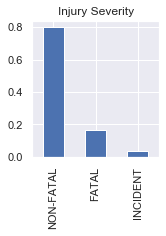

In [66]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1);aviationCatData.InjurySeverity.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Injury Severity')

#### Aircraft Damage

In [67]:
pd.DataFrame(aviationCatData.AircraftDamage.value_counts())

,AircraftDamage
SUBSTANTIAL,10837
DESTROYED,1680
MINOR,437


Text(0.5, 1.0, 'Aircraft Damage')

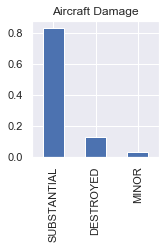

In [68]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1);aviationCatData.AircraftDamage.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Aircraft Damage')

#### Number of Engines

In [69]:
pd.DataFrame(aviationCatData.EngineCount.value_counts())

,EngineCount
1,10371
2,2016
4,527
3,40


Text(0.5, 1.0, 'Number of Engines')

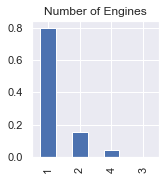

In [70]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1);aviationCatData.EngineCount.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Number of Engines')

#### Engine Type

In [71]:
pd.DataFrame(aviationCatData.EngineType.value_counts())

,EngineType
RECIPROCATING,11286
TURBO PROP,599
TURBO FAN,547
UNKNOWN,406
TURBO JET,116


Text(0.5, 1.0, 'Engine Type')

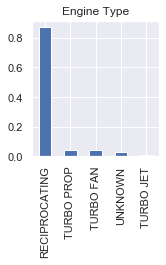

In [72]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1);aviationCatData.EngineType.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Engine Type')

#### Purpose of Flight

In [73]:
pd.DataFrame(aviationCatData.FlightPurpose.value_counts())

,FlightPurpose
PERSONAL,9985
UNKNOWN,1568
BUSINESS,629
POSITIONING,248
FERRY,137
EXECUTIVE/CORPORATE,110
PUBLIC AIRCRAFT,100
OTHER WORK USE,91
FLIGHT TEST,86


Text(0.5, 1.0, 'Purpose of Flight')

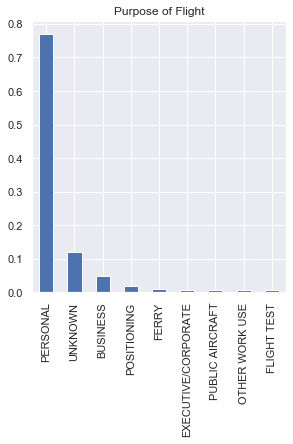

In [74]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1);aviationCatData.FlightPurpose.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Purpose of Flight')

#### Weather Condition

In [75]:
pd.DataFrame(aviationCatData.Weather.value_counts())

,Weather
VMC,12026
IMC,928


Text(0.5, 1.0, 'Weather Condition')

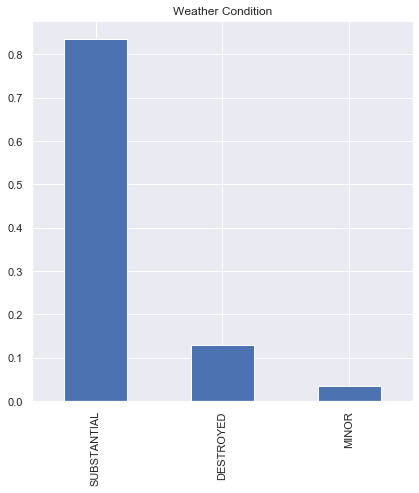

In [76]:
plt.figure(figsize = (15, 7))
plt.subplot(1, 2, 1)
aviationCatData.AircraftDamage.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Weather Condition')

#### Phase of Flight

In [77]:
pd.DataFrame(aviationCatData.Phase.value_counts())

,Phase
LANDING,4755
TAKEOFF,2940
APPROACH,1404
CRUISE,1139
MANEUVERING,859
TAXI,545
DESCENT,421
CLIMB,334
GO-AROUND,303
STANDING,254


Text(0.5, 1.0, 'Phase of Flight')

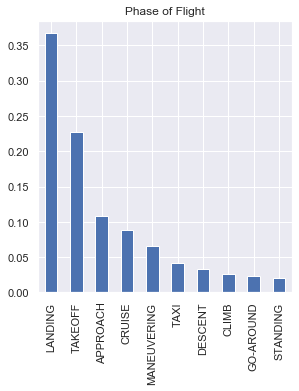

In [78]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1);aviationCatData.Phase.value_counts(normalize = True).plot(kind = 'bar'); plt.title('Phase of Flight')

In [79]:
compare = aviationCatData.groupby("AircraftDamage").InjurySeverity.value_counts(normalize = True)
compare.unstack()

InjurySeverity,FATAL,INCIDENT,NON-FATAL
AircraftDamage,,,
DESTROYED,0.698214,0.027381,0.274405
MINOR,0.038902,0.672769,0.288330
SUBSTANTIAL,0.091077,0.008859,0.900065


Text(0.5, 1.0, 'Injury severity at each level of aircraft damage')

<Figure size 1440x720 with 0 Axes>

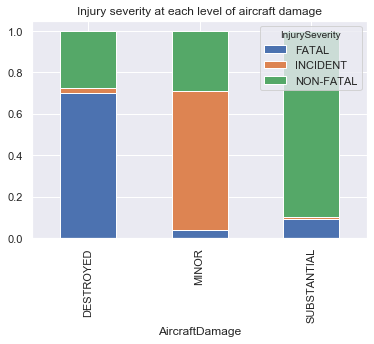

In [80]:
plt.figure(figsize = (20, 10))
compare.unstack().plot(kind='bar', stacked = True); plt.title('Injury severity at each level of aircraft damage')

In [81]:
compare = aviationCatData.groupby("Phase").InjurySeverity.value_counts(normalize = True)
compare.unstack()

InjurySeverity,FATAL,INCIDENT,NON-FATAL
Phase,,,
APPROACH,0.277778,0.038462,0.683761
CLIMB,0.323353,0.098802,0.577844
CRUISE,0.324846,0.040386,0.634767
DESCENT,0.270784,0.042755,0.686461
GO-AROUND,0.267327,0.026403,0.706271
LANDING,0.014932,0.025026,0.960042
MANEUVERING,0.566938,0.008149,0.424913
STANDING,0.074803,0.059055,0.866142
TAKEOFF,0.181633,0.034354,0.784014


Text(0.5, 1.0, 'Injury severity at different phases')

<Figure size 1440x720 with 0 Axes>

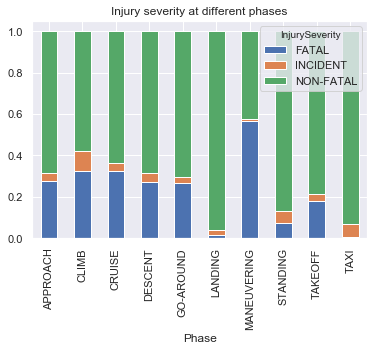

In [82]:
plt.figure(figsize = (20, 10))
compare.unstack().plot(kind='bar', stacked = True); plt.title('Injury severity at different phases')

In [83]:
compare = aviationCatData.groupby("Weather").AircraftDamage.value_counts(normalize = True)
compare.unstack()

AircraftDamage,DESTROYED,MINOR,SUBSTANTIAL
Weather,,,
IMC,0.411638,0.034483,0.553879
VMC,0.107933,0.033677,0.858390


Text(0.5, 1.0, 'Aircraft Damage at each weather condition')

<Figure size 1080x720 with 0 Axes>

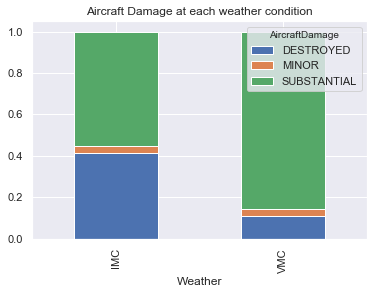

In [84]:
plt.figure(figsize = (15, 10))
compare.unstack().plot(kind='bar', stacked = True); plt.title('Aircraft Damage at each weather condition')

In [85]:
compare = aviationCatData.groupby("Phase").AircraftDamage.value_counts(normalize = True)
compare.unstack()

AircraftDamage,DESTROYED,MINOR,SUBSTANTIAL
Phase,,,
APPROACH,0.170940,0.027066,0.801994
CLIMB,0.269461,0.053892,0.676647
CRUISE,0.320457,0.028095,0.651449
DESCENT,0.182898,0.028504,0.788599
GO-AROUND,0.181518,0.029703,0.788779
LANDING,0.029863,0.020820,0.949317
MANEUVERING,0.327125,0.011641,0.661234
STANDING,0.043307,0.251969,0.704724
TAKEOFF,0.140476,0.020748,0.838776


Text(0.5, 1.0, 'Aircraft Damage at each phase')

<Figure size 1440x720 with 0 Axes>

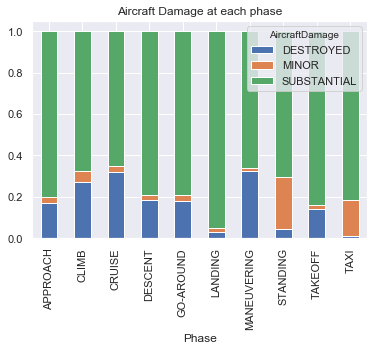

In [86]:
plt.figure(figsize = (20, 10))
compare.unstack().plot(kind='bar', stacked = True); plt.title('Aircraft Damage at each phase')

Text(0.5, 1.0, 'Injury severity at different phases')

<Figure size 1440x720 with 0 Axes>

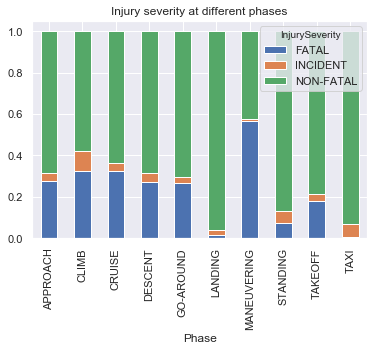

In [87]:
compare = aviationCatData.groupby("Phase").InjurySeverity.value_counts(normalize = True)
compare.unstack()
plt.figure(figsize = (20, 10))
compare.unstack().plot(kind='bar', stacked = True); plt.title('Injury severity at different phases')

In [88]:
aviationCatData

,InjurySeverity,AircraftDamage,EngineCount,EngineType,FlightPurpose,Weather,Phase
0,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,VMC,STANDING
1,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,VMC,TAXI
2,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,VMC,STANDING
3,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,VMC,TAXI
4,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,VMC,STANDING
...,...,...,...,...,...,...,...
12949,NON-FATAL,DESTROYED,1,RECIPROCATING,PERSONAL,VMC,LANDING
12950,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,BUSINESS,VMC,TAXI
12951,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,UNKNOWN,VMC,LANDING
12952,NON-FATAL,SUBSTANTIAL,2,RECIPROCATING,UNKNOWN,VMC,TAKEOFF


### Numerical Data

In [89]:
aviationNumData = pd.DataFrame(aviationData[['Altitude', 'Total.Fatal.Injuries', 'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured', 'Total.Passengers']])

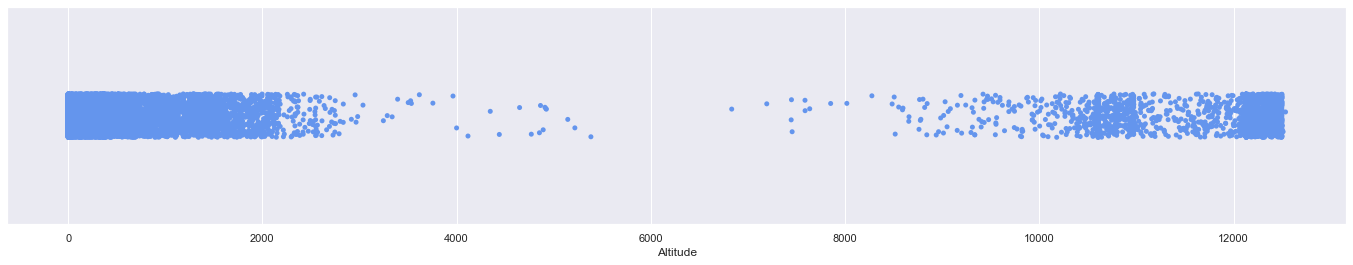

In [90]:
f, axes = plt.subplots(1, 1, figsize=(24, 4))
sb.stripplot(aviationNumData['Altitude'], orient = "h", color = "cornflowerblue")

In [91]:
aviationNumData.describe()

,Altitude,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Total.Passengers
count,12954.000000,12954.000000,12954.000000,12954.000000,12954.000000,12954.000000
mean,2449.158847,0.414775,0.173614,0.309788,5.720241,6.618419
std,4303.358552,3.409520,0.765511,1.835256,29.584821,30.029360
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,195.200000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,367.200000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,1341.200000,0.000000,0.000000,0.000000,2.000000,3.000000
max,12534.600000,228.000000,50.000000,137.000000,588.000000,588.000000


In [92]:
aviationNumData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 6 columns):
Altitude                  12954 non-null float64
Total.Fatal.Injuries      12954 non-null int64
Total.Serious.Injuries    12954 non-null int64
Total.Minor.Injuries      12954 non-null int64
Total.Uninjured           12954 non-null int64
Total.Passengers          12954 non-null int64
dtypes: float64(1), int64(5)
memory usage: 607.3 KB


In [93]:
aviationNumData['Altitude'].describe()

count    12954.000000
mean      2449.158847
std       4303.358552
min          0.000000
25%        195.200000
50%        367.200000
75%       1341.200000
max      12534.600000
Name: Altitude, dtype: float64

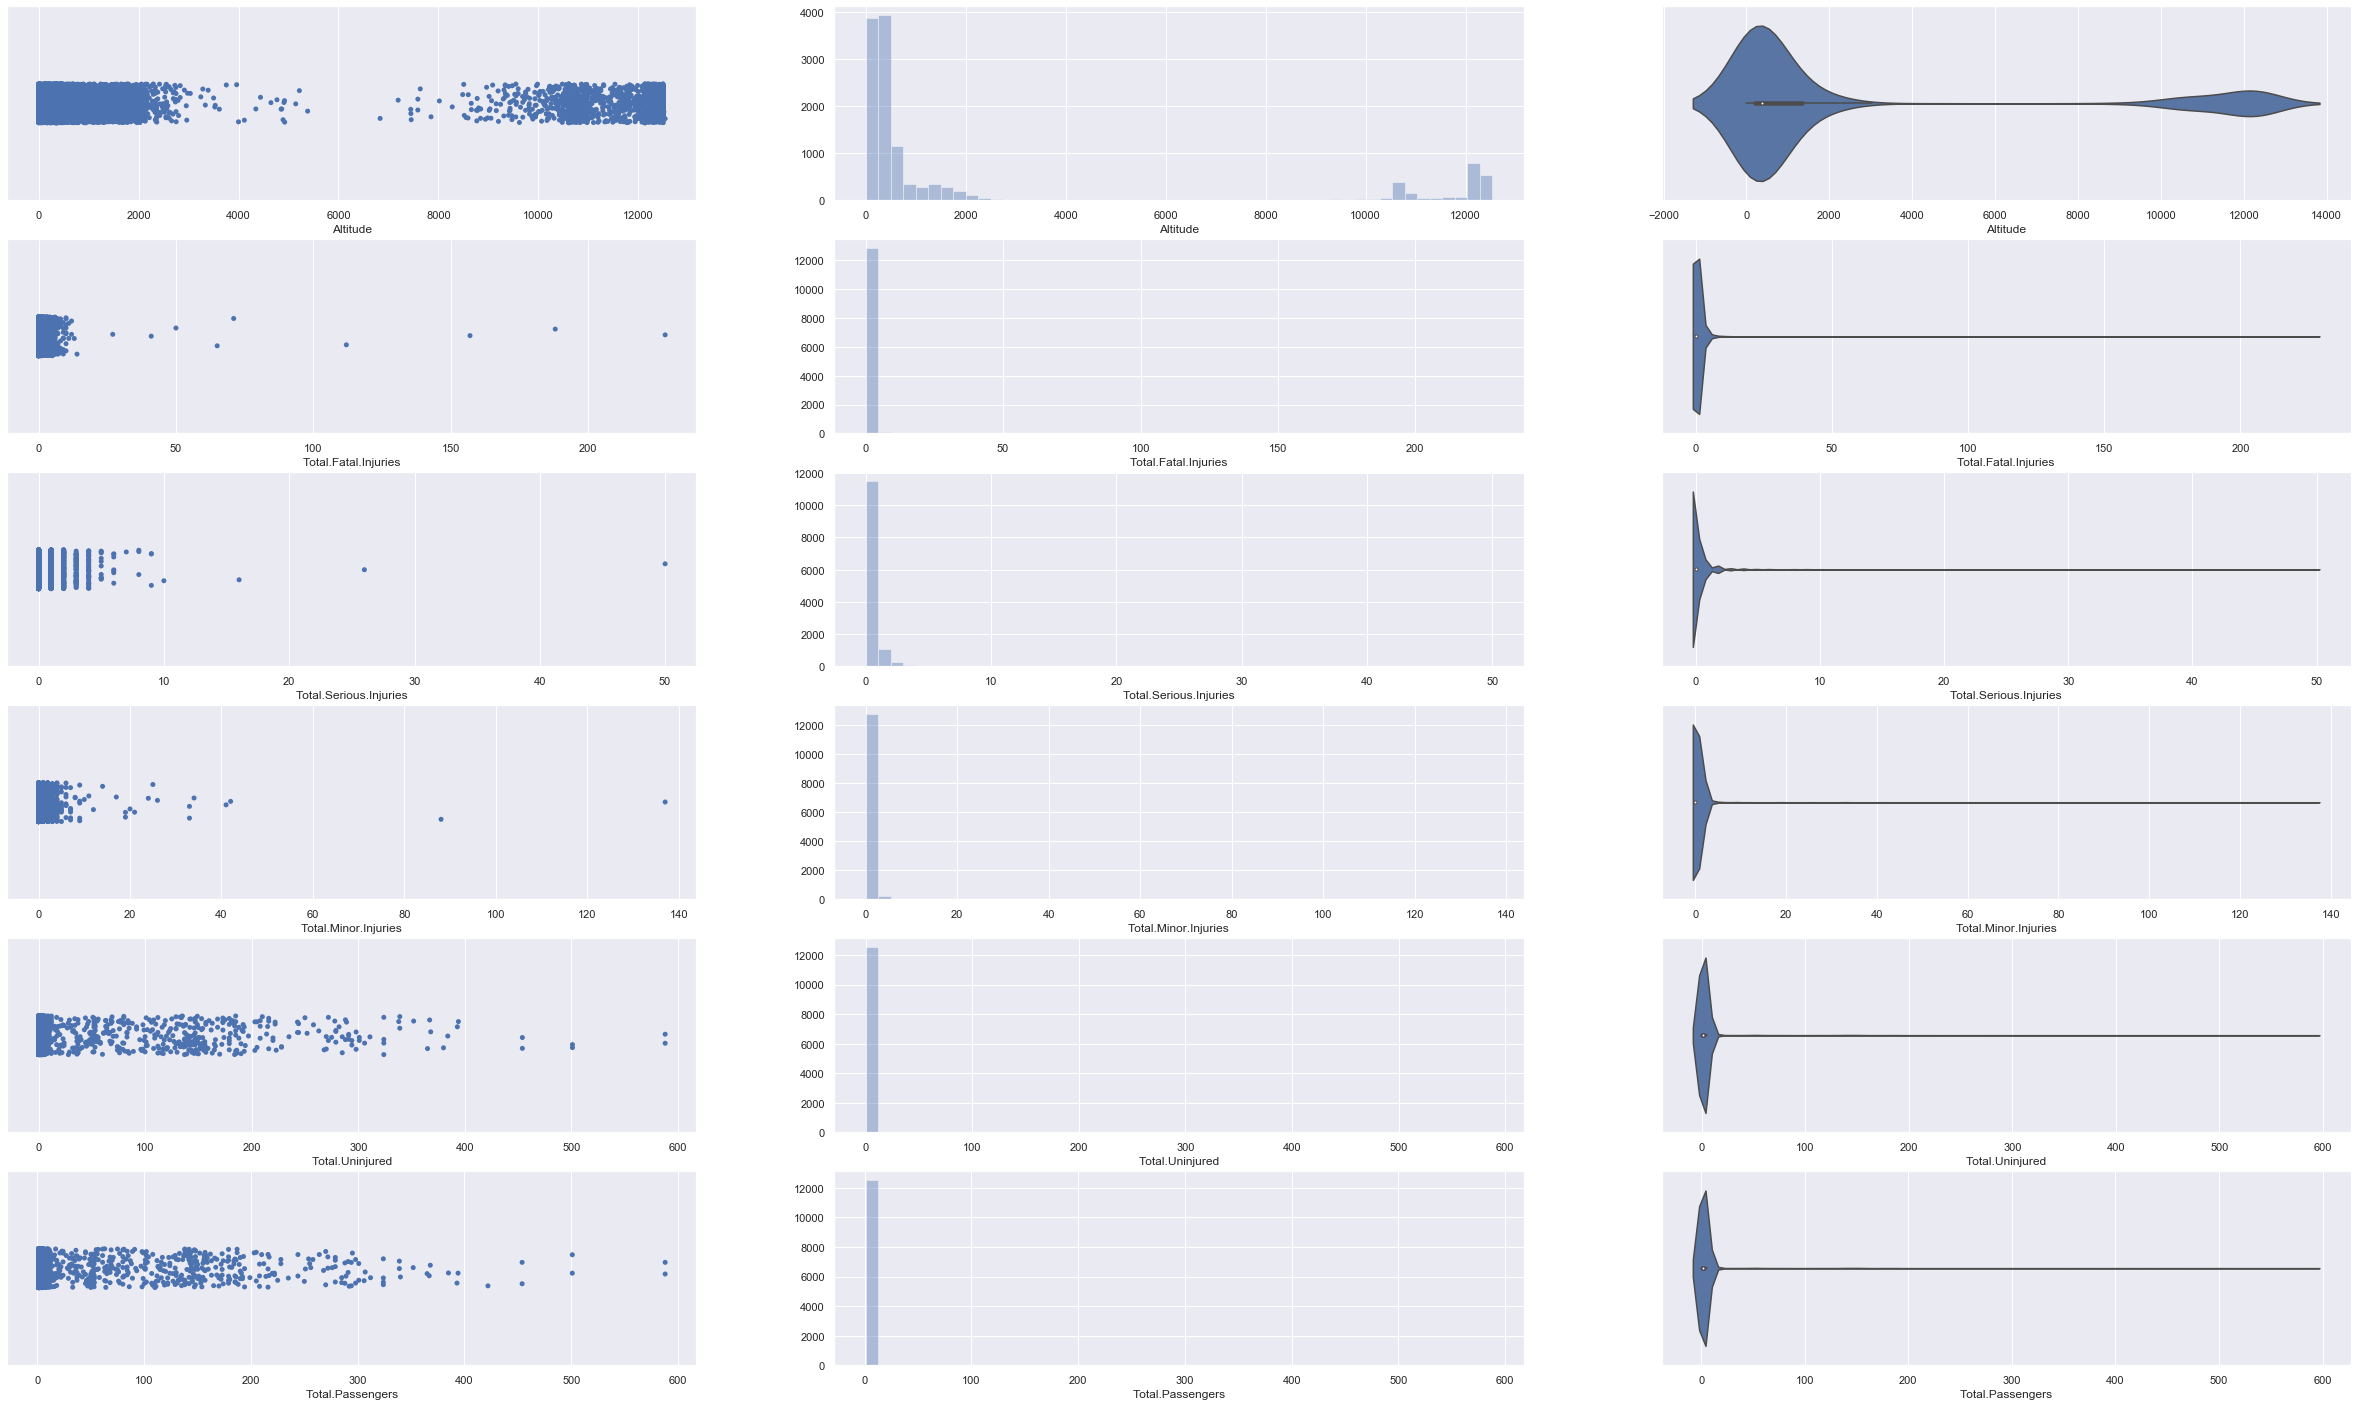

In [94]:
count = 0
f, axes = plt.subplots(6, 3, figsize=(42, 25))

for i in aviationNumData:
    sb.stripplot(aviationData[i], orient = "h", ax = axes[count,0])
    sb.distplot(aviationData[i], kde = False, ax = axes[count,1])
    sb.violinplot(aviationData[i], ax = axes[count,2])
    count += 1

                        Altitude  Total.Fatal.Injuries  \
Altitude                1.000000              0.059269   
Total.Fatal.Injuries    0.059269              1.000000   
Total.Serious.Injuries  0.036064              0.198422   
Total.Minor.Injuries    0.005459             -0.007162   
Total.Uninjured        -0.050748             -0.021292   
Total.Passengers       -0.042014              0.097184   

                        Total.Serious.Injuries  Total.Minor.Injuries  \
Altitude                              0.036064              0.005459   
Total.Fatal.Injuries                  0.198422             -0.007162   
Total.Serious.Injuries                1.000000              0.460017   
Total.Minor.Injuries                  0.460017              1.000000   
Total.Uninjured                       0.048355              0.099347   
Total.Passengers                      0.123774              0.169905   

                        Total.Uninjured  Total.Passengers  
Altitude                    

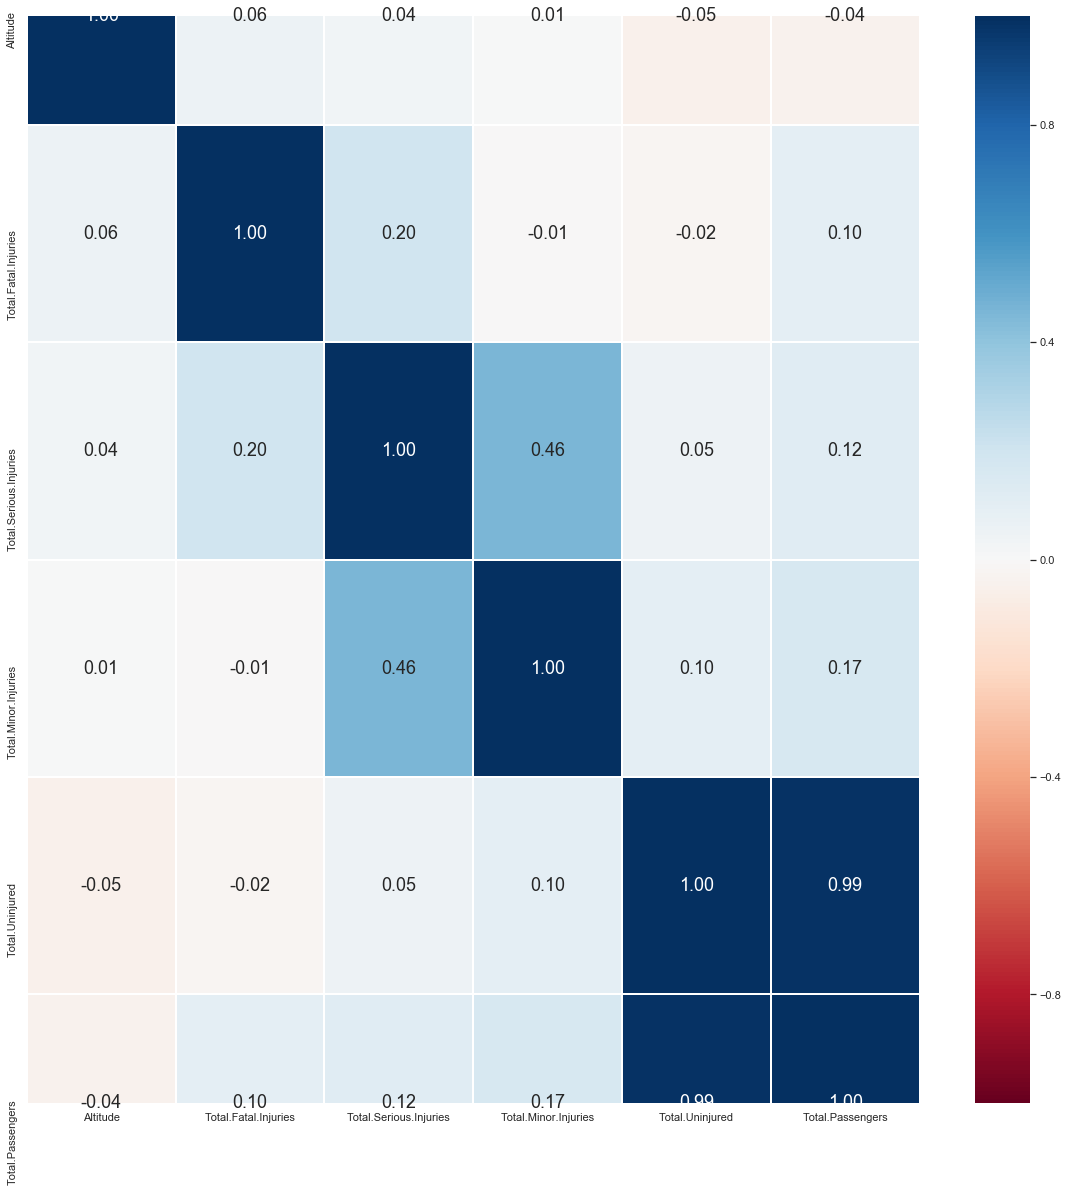

In [95]:
print(aviationNumData.corr())
f, axes = plt.subplots(1, 1, figsize=(20, 20))
sb.heatmap(aviationNumData.corr(), vmin = -1, vmax = 1, linewidths = 1, annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

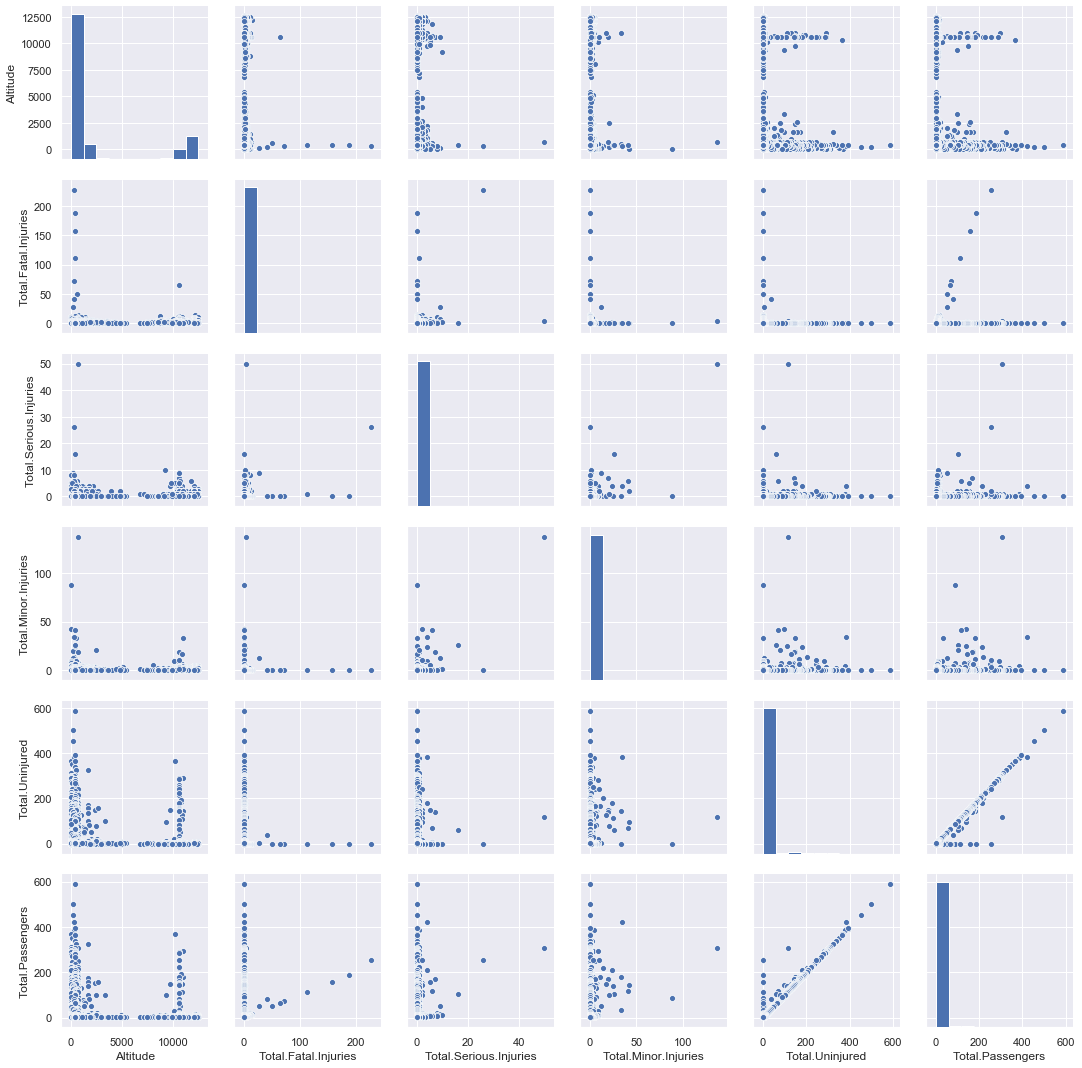

In [96]:
sb.pairplot(data = aviationNumData)

## Visualizing relationships between Numerical and Categorical Data

In [97]:
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12949,367.2,39.164723,-96.610412,NON-FATAL,DESTROYED,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,LANDING,1
12950,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,BUSINESS,0,0,0,1,VMC,TAXI,1
12951,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,UNKNOWN,0,0,0,1,VMC,LANDING,1
12952,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,2,RECIPROCATING,UNKNOWN,0,0,1,0,VMC,TAKEOFF,1


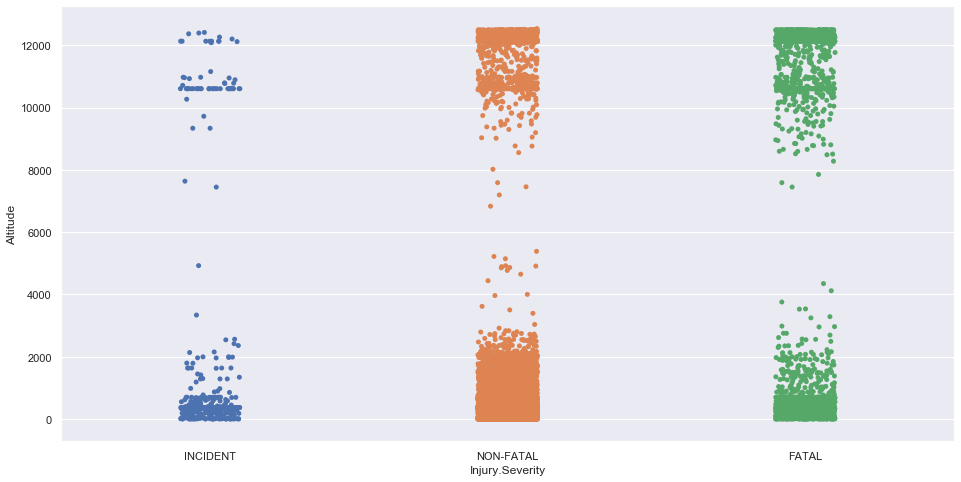

In [98]:
f, axes = plt.subplots(1, 1, figsize=(16, 8))
sb.stripplot(x = 'Injury.Severity', y = 'Altitude', data = aviationData)

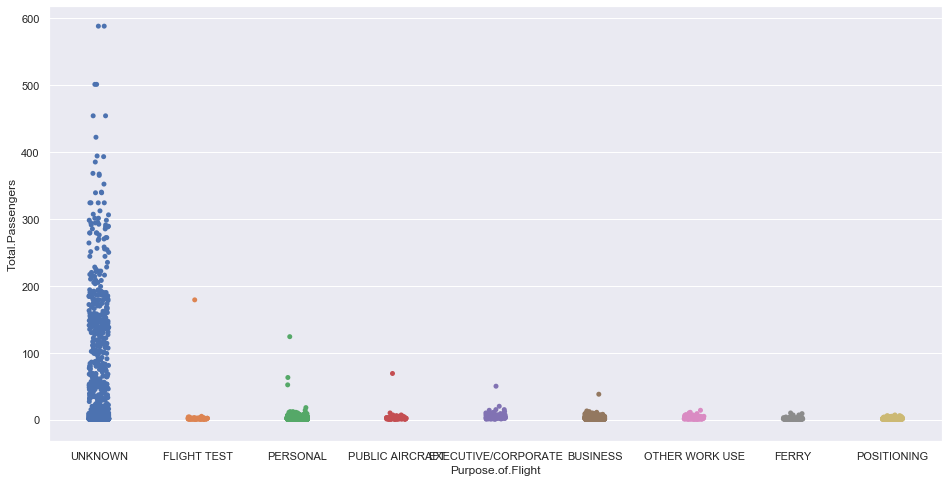

In [99]:
f, axes = plt.subplots(1, 1, figsize=(16, 8))
sb.stripplot(x = 'Purpose.of.Flight', y = 'Total.Passengers', data = aviationData)

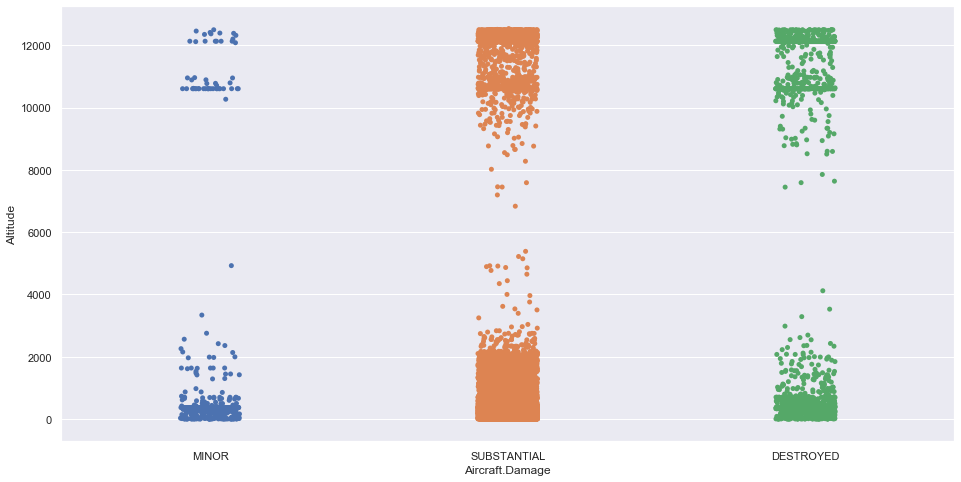

In [100]:
f, axes = plt.subplots(1, 1, figsize=(16, 8))
sb.stripplot(x = 'Aircraft.Damage', y = 'Altitude', data = aviationData)

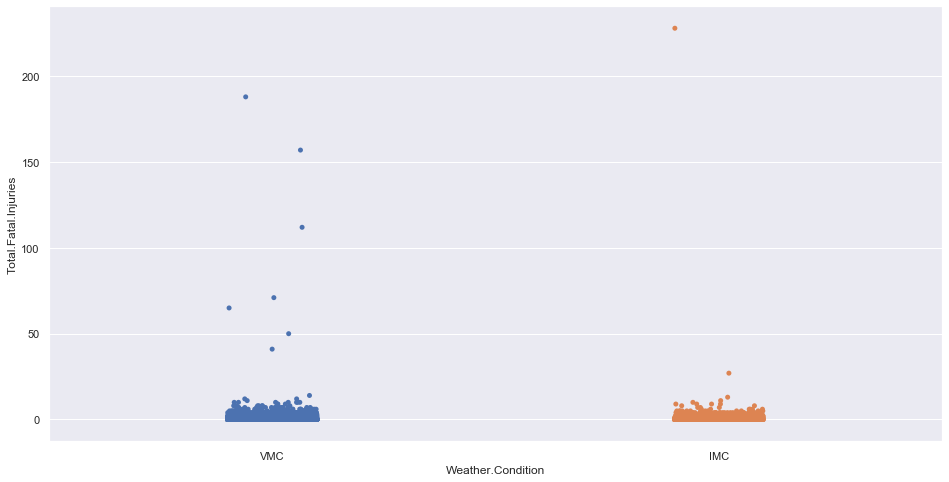

In [101]:
f, axes = plt.subplots(1, 1, figsize=(16, 8))
sb.stripplot(x = 'Weather.Condition', y = 'Total.Fatal.Injuries', data = aviationData)

# Prediction of aircraft damage using altitude and passenger count

In [102]:
# aviationData = pd.read_csv('Intermediate.csv')
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12949,367.2,39.164723,-96.610412,NON-FATAL,DESTROYED,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,LANDING,1
12950,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,BUSINESS,0,0,0,1,VMC,TAXI,1
12951,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,UNKNOWN,0,0,0,1,VMC,LANDING,1
12952,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,2,RECIPROCATING,UNKNOWN,0,0,1,0,VMC,TAKEOFF,1


In [103]:
# Extract Response and Predictors
y = pd.DataFrame(aviationData["Aircraft.Damage"])
X = pd.DataFrame(aviationData[["Altitude", "Latitude", "Longitude", "Total.Uninjured", "Total.Passengers"]])

In [104]:
y.columns = ['AircraftDamage']
X.columns = ['Altitude', 'Latitude', 'Longitude', 'TotalUninjured', 'TotalPassengers']
pd.DataFrame(y.AircraftDamage.value_counts())

,AircraftDamage
SUBSTANTIAL,10837
DESTROYED,1680
MINOR,437


In [105]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Check the sample sizes
print("Train Set :", y_train.shape, X_train.shape)
print("Test Set  :", y_test.shape, X_test.shape)

Train Set : (10363, 1) (10363, 5)
Test Set  : (2591, 1) (2591, 5)


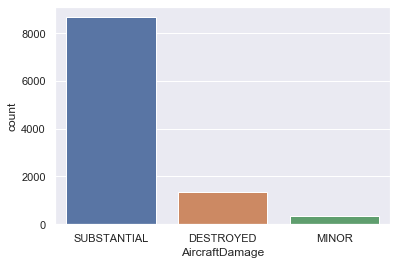

In [106]:
sb.countplot(y_train["AircraftDamage"])

In [107]:
columns = X_train.columns.tolist()
target = 'AircraftDamage'
state = np.random.RandomState(42)
print(X_train.shape)
print(y_train.shape)

(10363, 5)
(10363, 1)


In [108]:
pd.DataFrame(y_train.AircraftDamage.value_counts())

,AircraftDamage
SUBSTANTIAL,8669
DESTROYED,1348
MINOR,346


In [109]:
#Near Miss instance for data balancing by oversampling minority classes
nm = NearMiss()
smk = SMOTETomek(random_state = 42)
X_train, y_train = smk.fit_sample(X_train, y_train)

In [110]:
pd.DataFrame(y_train.AircraftDamage.value_counts())

,AircraftDamage
MINOR,8486
DESTROYED,8356
SUBSTANTIAL,8315


In [111]:
# Summary Statistics for Predictors
X_train.describe()

,Altitude,Latitude,Longitude,TotalUninjured,TotalPassengers
count,25157.000000,25157.000000,25157.000000,25157.000000,25157.000000
mean,2929.844301,38.362764,-94.851752,20.034583,21.243232
std,4660.349876,8.037418,26.292661,63.198806,63.268074
min,0.000000,-78.016945,-171.734722,0.000000,1.000000
25%,241.200000,36.142739,-98.150833,0.000000,1.000000
50%,367.200000,39.164723,-96.610412,1.000000,2.000000
75%,1867.536116,39.776947,-87.730005,3.000000,4.000000
max,12534.600000,70.489722,165.147777,588.000000,588.000000


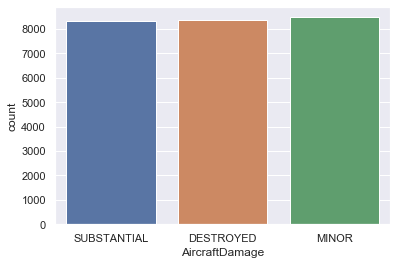

In [112]:
# Draw the distribution of Response
sb.countplot(y_train["AircraftDamage"])

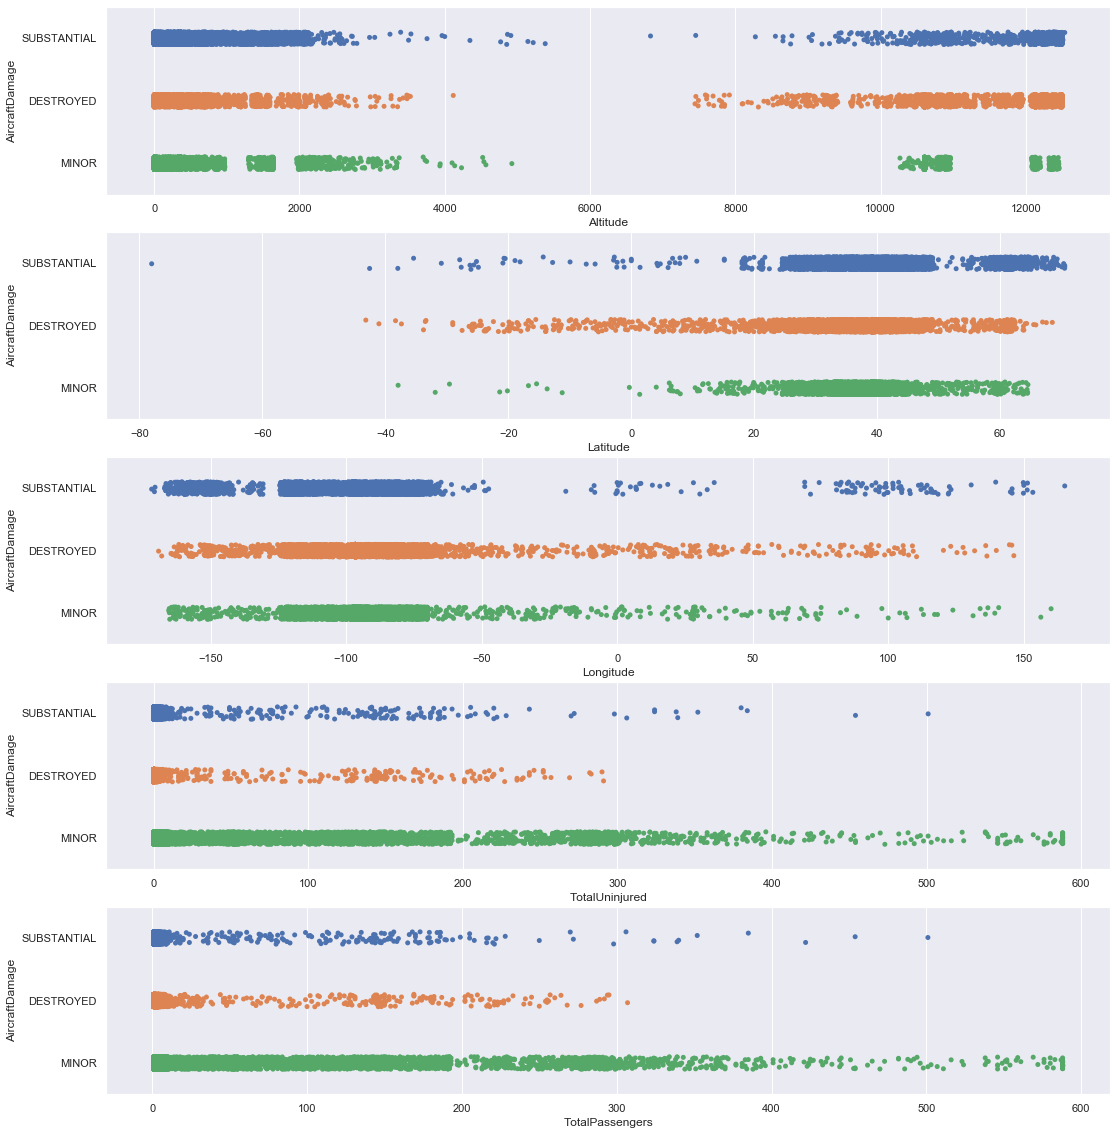

In [113]:
# Relationship between Response and the Predictors
trainDF = pd.concat([y_train, X_train.reindex(index=y_train.index)], sort = False, axis = 1)

f, axes = plt.subplots(5, 1, figsize=(18, 20))

count = 0
for var in X_train:
    sb.stripplot(x = var, y = "AircraftDamage", data = trainDF, orient = "h", ax = axes[count])
    count += 1

In [114]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
dectree.fit(X_train, y_train)                    # train the decision tree model

# Predict Response corresponding to Predictors
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)

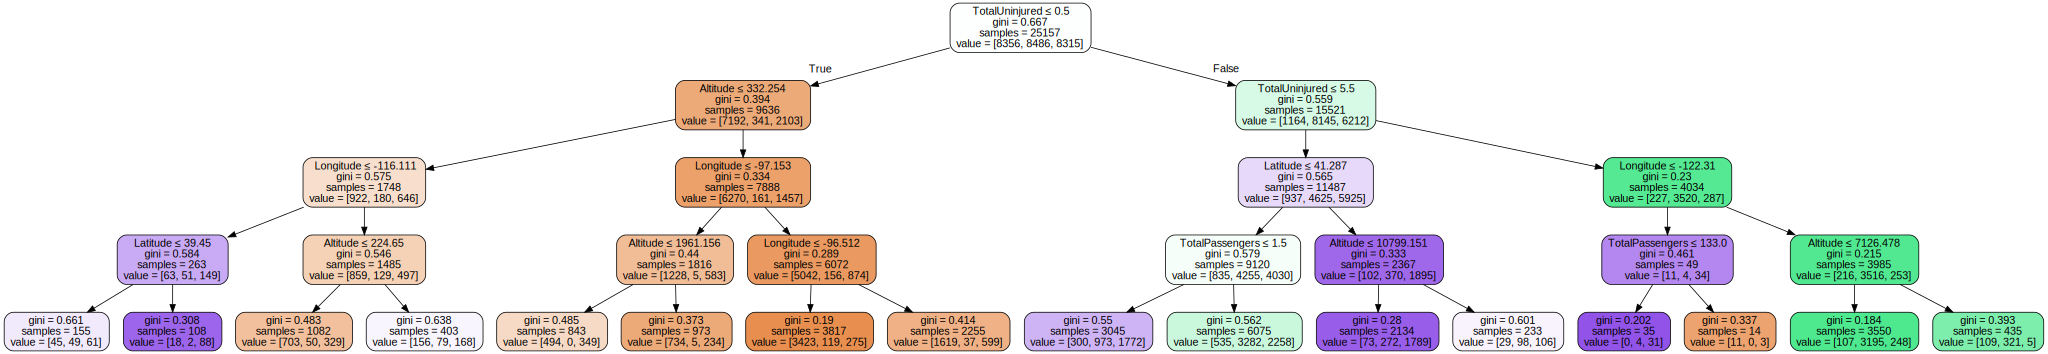

In [115]:
# Plot the Decision Tree
treedot = export_graphviz(dectree,                                      # the model
                          feature_names = X_train.columns,              # the features 
                          out_file = None,                              # output file
                          filled = True,                                # node colors
                          rounded = True,                               # make pretty
                          special_characters = True)                    # postscript

graphviz.Source(treedot)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 70.74372937949676 %

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 50.71401003473562 %



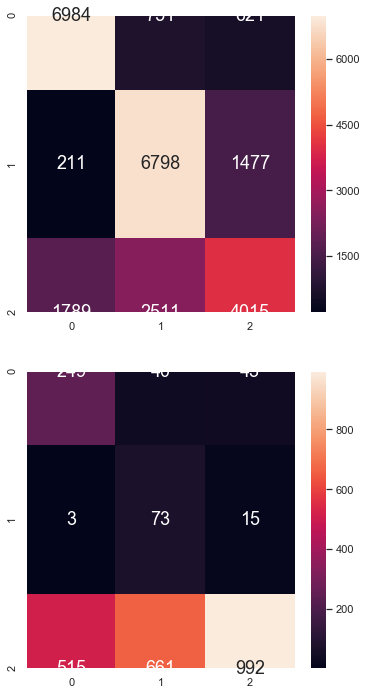

In [116]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train)*100, "%")
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test)*100,"%")
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(2, 1, figsize=(6, 12))
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [117]:
#Boosting the base tree with AdaBoost
AdaBoost = AdaBoostClassifier(base_estimator = dectree, 
                              n_estimators = 175, learning_rate = 0.3)
boostModel = AdaBoost.fit(X_train,y_train)

pred = boostModel.predict(X_train)
predictions = metrics.accuracy_score(y_train,pred)
print("prediction accuracy of train set is: ",predictions*100,"%")

pred = boostModel.predict(X_test)
predictions = metrics.accuracy_score(y_test,pred)
print("prediction accuracy of test set is: ",predictions*100,"%")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


prediction accuracy of train set is:  78.01407163016258 %
prediction accuracy of test set is:  69.39405634890004 %


# Linear Regression to predict Fatal/Serious/Minor injuries

In [118]:
linreg = LinearRegression()

In [119]:
aviationData['Total.Passengers'] = aviationData["Total.Passengers"].astype(float)

In [120]:
predictors = pd.DataFrame(aviationData[['Total.Passengers', 'Altitude']])
predictors.head()

,Total.Passengers,Altitude
0,588.0,367.2
1,588.0,367.2
2,501.0,202.7
3,501.0,202.7
4,454.0,215.4


Intercept of Regression 	: b =  [0.214182]
Coefficients of Regression 	: a =  [[1.36944403e-02 5.03234804e-05]]

         Predictors  Coefficients
0  Total.Passengers      0.013694
1          Altitude      0.000050



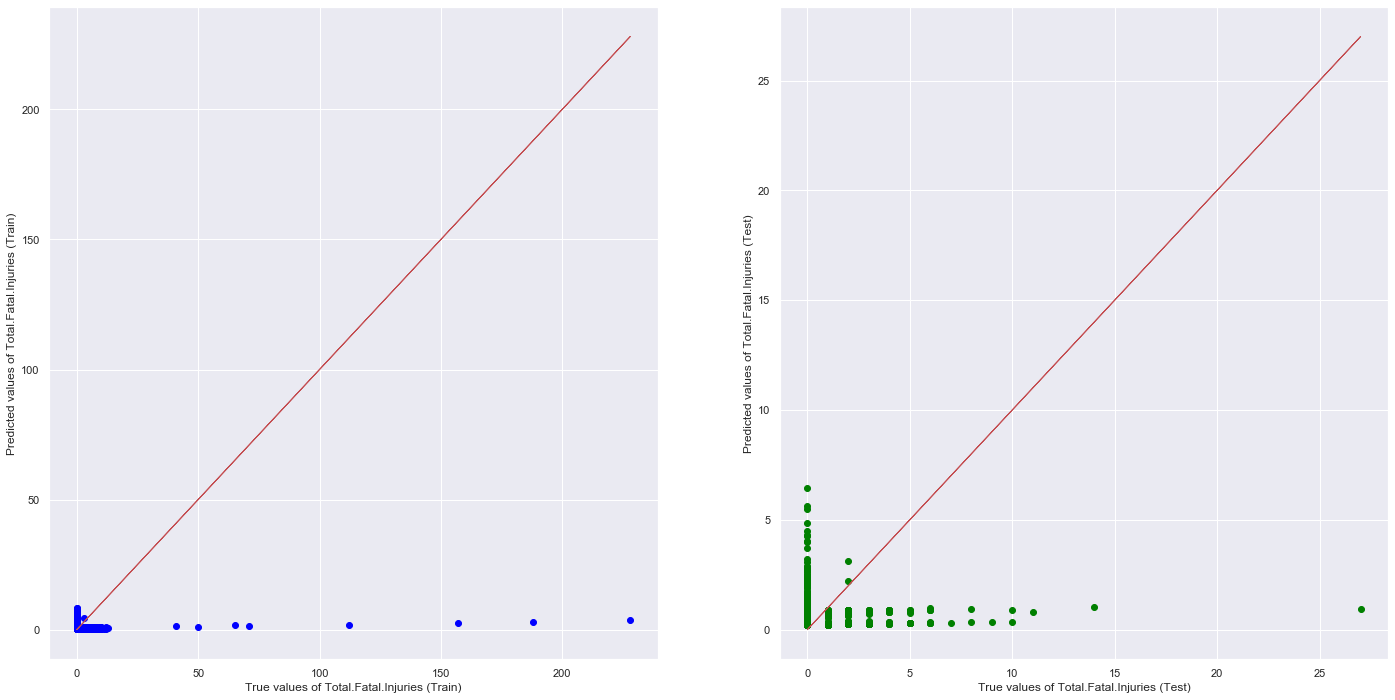

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.015076255943056836
Mean Squared Error (MSE) 	: 13.989157227955758

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: -0.07976232629214541
Mean Squared Error (MSE) 	: 1.4073399469595584



In [121]:
x = predictors
y = pd.DataFrame(aviationData["Total.Fatal.Injuries"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
linreg.fit(x_train, y_train)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

print(pd.DataFrame(list(zip(x_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

y_train_pred = linreg.predict(x_train)
y_test_pred = linreg.predict(x_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of Total.Fatal.Injuries (Train)")
axes[0].set_ylabel("Predicted values of Total.Fatal.Injuries (Train)")


axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of Total.Fatal.Injuries (Test)")
axes[1].set_ylabel("Predicted values of Total.Fatal.Injuries (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Intercept of Regression 	: b =  [0.13564726]
Coefficients of Regression 	: a =  [[3.49731009e-03 7.19331615e-06]]

         Predictors  Coefficients
0  Total.Passengers      0.003497
1          Altitude      0.000007



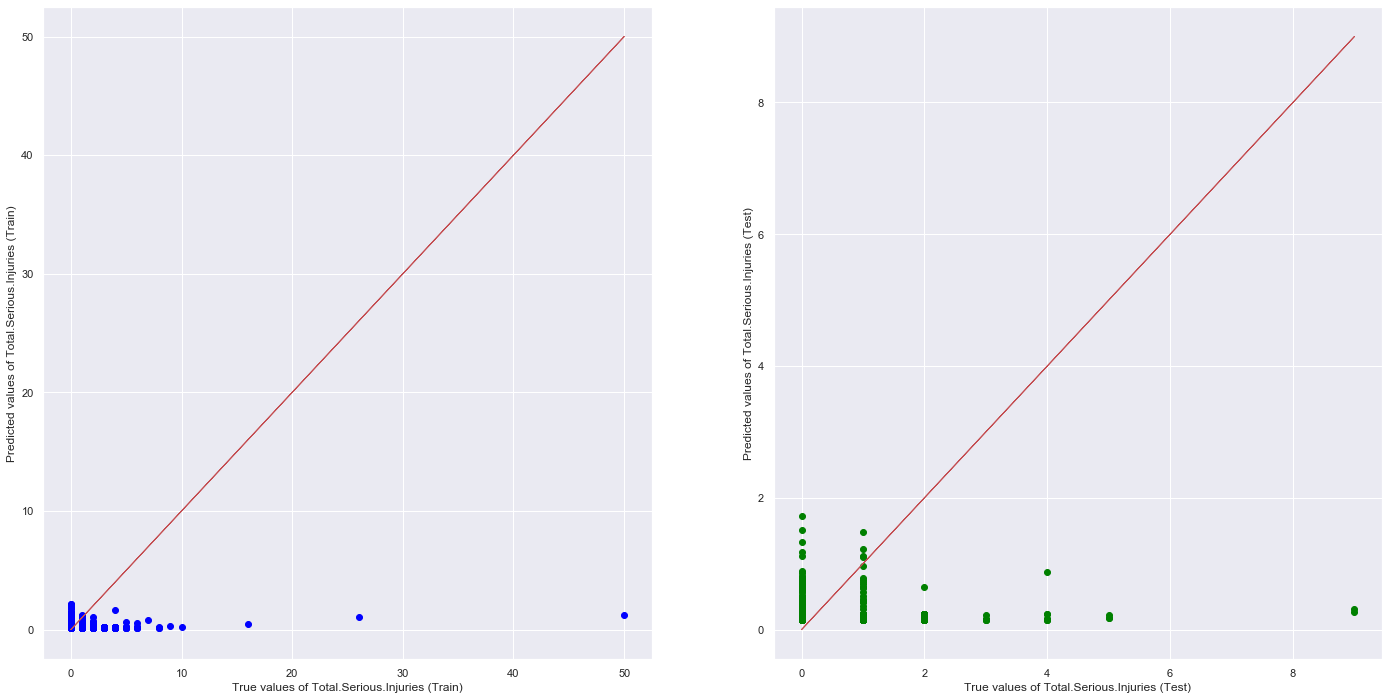

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.018493588530821836
Mean Squared Error (MSE) 	: 0.6407767313329855

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.0030056725610009267
Mean Squared Error (MSE) 	: 0.31728547291084563



In [122]:
x = predictors
y = pd.DataFrame(aviationData["Total.Serious.Injuries"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)

linreg.fit(x_train, y_train)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

print(pd.DataFrame(list(zip(x_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

y_train_pred = linreg.predict(x_train)
y_test_pred = linreg.predict(x_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of Total.Serious.Injuries (Train)")
axes[0].set_ylabel("Predicted values of Total.Serious.Injuries (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of Total.Serious.Injuries (Test)")
axes[1].set_ylabel("Predicted values of Total.Serious.Injuries (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

Intercept of Regression 	: b =  [0.2266774]
Coefficients of Regression 	: a =  [[1.10712188e-02 4.78371507e-06]]

         Predictors  Coefficients
0  Total.Passengers      0.011071
1          Altitude      0.000005



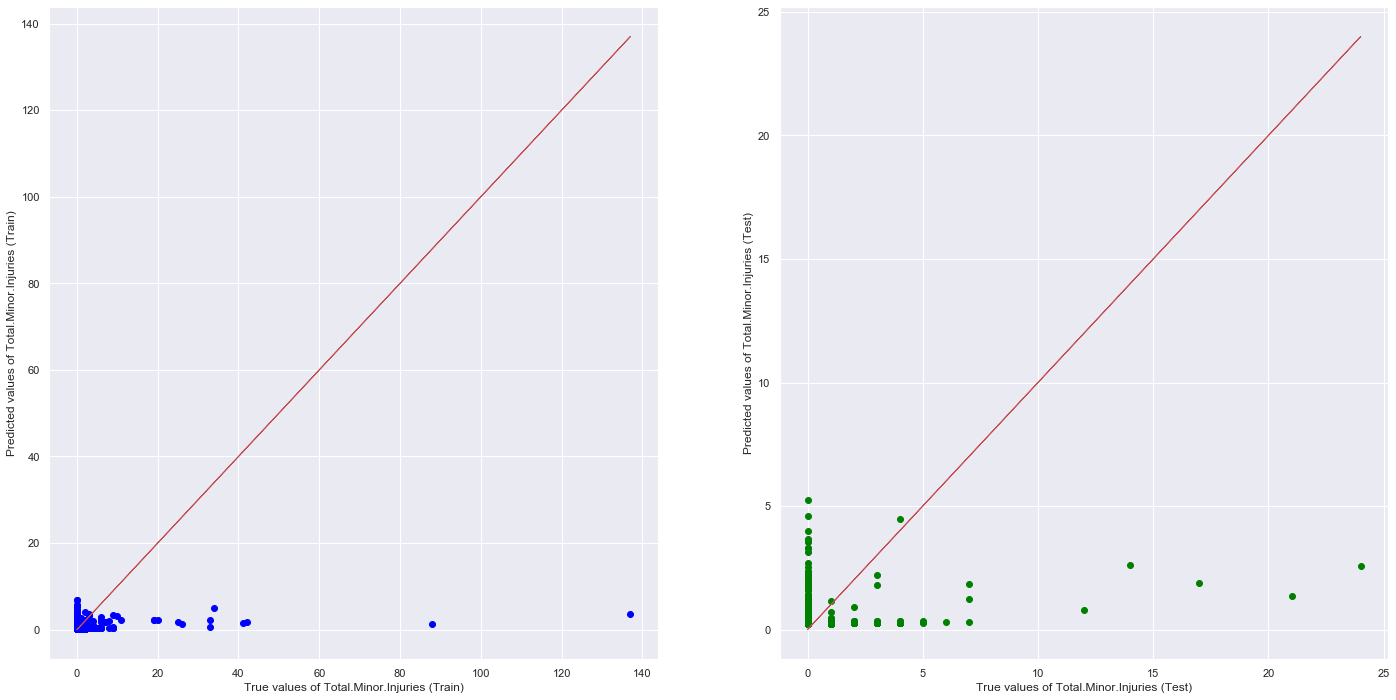

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.029023836604770925
Mean Squared Error (MSE) 	: 3.810693696262364

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.027176950044232265
Mean Squared Error (MSE) 	: 1.1101618591637585



In [123]:
x = predictors
y = pd.DataFrame(aviationData["Total.Minor.Injuries"])


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)

linreg.fit(x_train, y_train)

print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

print(pd.DataFrame(list(zip(x_train.columns, linreg.coef_[0])), columns = ["Predictors", "Coefficients"]))
print()

y_train_pred = linreg.predict(x_train)
y_test_pred = linreg.predict(x_test)

f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, y_train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of Total.Minor.Injuries (Train)")
axes[0].set_ylabel("Predicted values of Total.Minor.Injuries (Train)")
axes[1].scatter(y_test, y_test_pred, color = "green")
axes[1].plot(y_test, y_test, 'r-', linewidth = 1)
axes[1].set_xlabel("True values of Total.Minor.Injuries (Test)")
axes[1].set_ylabel("Predicted values of Total.Minor.Injuries (Test)")
plt.show()

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(x_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

In [124]:
aviationData = pd.read_csv('intermediate.csv')
aviationData

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13005,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,FERRY,0,0,0,1,VMC,CRUISE,1
13006,367.2,39.164723,-96.610412,INCIDENT,MINOR,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,APPROACH,1
13007,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,FERRY,0,0,0,1,VMC,TAKEOFF,1
13008,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,TAXI,1


In [125]:
maneuvering = pd.DataFrame(aviationData[aviationData["Broad.Phase.of.Flight"] == 'MANEUVERING'])
maneuvering

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
443,367.2,55.425556,-131.505000,FATAL,SUBSTANTIAL,1,TURBO PROP,UNKNOWN,6,9,1,0,VMC,MANEUVERING,16
444,367.2,55.425556,-131.505000,FATAL,DESTROYED,1,RECIPROCATING,UNKNOWN,6,9,1,0,VMC,MANEUVERING,16
453,302.1,45.950000,-112.483333,FATAL,SUBSTANTIAL,1,TURBO PROP,PERSONAL,14,0,0,0,VMC,MANEUVERING,14
459,367.2,9.865278,-85.366111,FATAL,DESTROYED,1,TURBO PROP,UNKNOWN,12,0,0,0,VMC,MANEUVERING,12
492,0.0,46.587222,-121.352222,FATAL,DESTROYED,1,TURBO PROP,PERSONAL,10,0,0,0,IMC,MANEUVERING,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12917,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,BUSINESS,0,0,0,1,VMC,MANEUVERING,1
12930,367.2,39.164723,-96.610412,NON-FATAL,DESTROYED,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,MANEUVERING,1
12937,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,PERSONAL,0,1,0,0,VMC,MANEUVERING,1
12950,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,1,RECIPROCATING,PERSONAL,0,0,0,1,VMC,MANEUVERING,1


In [126]:
maneuvering['Injury.Severity'].value_counts()

FATAL        490
NON-FATAL    367
INCIDENT       8
Name: Injury.Severity, dtype: int64

In [127]:
maneuvering['Aircraft.Damage'].value_counts()

SUBSTANTIAL    572
DESTROYED      283
MINOR           10
Name: Aircraft.Damage, dtype: int64

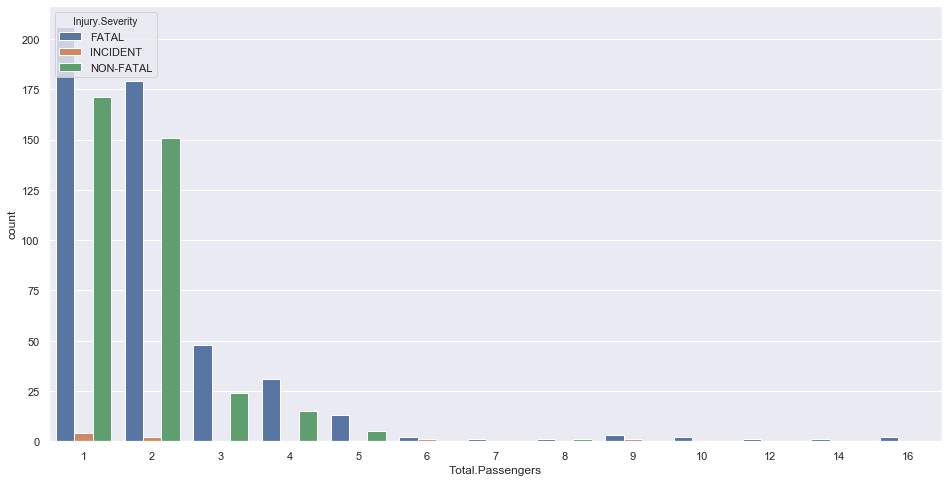

In [128]:
f, axes = plt.subplots(1, 1, figsize=(16, 8))
sb.countplot(x = 'Total.Passengers', hue = 'Injury.Severity', data = maneuvering)

In [129]:
more = pd.DataFrame(aviationData[aviationData['Total.Passengers'] > 15])
less = pd.DataFrame(aviationData[aviationData['Total.Passengers'] < 15])
more

,Altitude,Latitude,Longitude,Injury.Severity,Aircraft.Damage,Number.of.Engines,Engine.Type,Purpose.of.Flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.Phase.of.Flight,Total.Passengers
0,367.2,39.164723,-96.610412,INCIDENT,MINOR,3,TURBO FAN,UNKNOWN,0,0,0,588,VMC,STANDING,588
1,367.2,39.164723,-96.610412,INCIDENT,MINOR,4,TURBO FAN,UNKNOWN,0,0,0,588,VMC,TAXI,588
2,202.7,41.968611,-87.907778,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,STANDING,501
3,202.7,41.968611,-87.907778,NON-FATAL,MINOR,2,TURBO FAN,UNKNOWN,0,0,0,501,VMC,TAXI,501
4,215.4,35.213611,-80.948889,NON-FATAL,SUBSTANTIAL,2,TURBO FAN,UNKNOWN,0,0,0,454,VMC,STANDING,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,367.2,55.425556,-131.505000,FATAL,SUBSTANTIAL,1,TURBO PROP,UNKNOWN,6,9,1,0,VMC,MANEUVERING,16
444,367.2,55.425556,-131.505000,FATAL,DESTROYED,1,RECIPROCATING,UNKNOWN,6,9,1,0,VMC,MANEUVERING,16
445,367.2,39.164723,-96.610412,INCIDENT,SUBSTANTIAL,4,UNKNOWN,UNKNOWN,0,0,0,16,NaN,TAKEOFF,16
446,367.2,39.164723,-96.610412,NON-FATAL,SUBSTANTIAL,2,TURBO PROP,UNKNOWN,0,0,2,14,IMC,LANDING,16


In [130]:
more['Injury.Severity'].value_counts()
print("NONFATAL: ", 245/442 * 100)
print("INCIDENT: ", 180/442 * 100)
print("FATAL: ", 17/442 * 100)

NONFATAL:  55.42986425339367
INCIDENT:  40.723981900452486
FATAL:  3.8461538461538463


In [131]:
aviationData['Injury.Severity'].value_counts()
print("NONFATAL: ", 10341/12954 * 100)
print("FATAL: ", 2177/12954 * 100)
print("INCIDENT: ", 436/12954 * 100)

NONFATAL:  79.82862436313108
FATAL:  16.805619885749575
INCIDENT:  3.3657557511193454


In [132]:
less['Injury.Severity'].value_counts()
print("NONFATAL: ", 10093/12507 * 100)
print("FATAL: ", 2159/12507 * 100)
print("INCIDENT: ", 255/12507 * 100)

NONFATAL:  80.6988086671464
FATAL:  17.262333093467657
INCIDENT:  2.0388582393859442


## Predicting whether an accident will be fatal using Altitude, Passenger Count and Weather Conditions? 

In [133]:
aviationData = aviationData.dropna()

In [134]:
a = pd.DataFrame(aviationData[['Altitude', 'Latitude', 'Longitude', 'Weather.Condition', 'Total.Passengers']])
b = pd.DataFrame(aviationData["Injury.Severity"])

In [135]:
b.columns = ['InjurySeverity']

In [136]:
for index, row in a.iterrows():
    if(row['Weather.Condition'] == 'IMC'):
        a.at[index, 'Weather.Condition'] = '1'
    else:
        a.at[index, 'Weather.Condition'] = '0'
        
a['Weather.Condition'] = a['Weather.Condition'].astype('int64')

In [137]:
from sklearn.model_selection import train_test_split

a_train, a_test, b_train, b_test = train_test_split(a, b, test_size = 0.20, random_state = 1)

print("Train Set :", a_train.shape, a_train.shape)
print("Test Set  :", b_test.shape, b_test.shape)

Train Set : (10036, 5) (10036, 5)
Test Set  : (2509, 1) (2509, 1)


In [138]:
#Data balancing starts here 
columns = a_train.columns.tolist()
target = 'InjurySeverity'
state = np.random.RandomState(42)
print(a_train.shape)
print(b_train.shape)

(10036, 5)
(10036, 1)


In [139]:
pd.DataFrame(b_train.InjurySeverity.value_counts())

,InjurySeverity
NON-FATAL,8137
FATAL,1621
INCIDENT,278


In [140]:
#Near miss instance for data balancing by oversampling minority classes
nm = NearMiss()
smk = SMOTETomek(random_state = 42)
a_train, b_train = smk.fit_sample(a_train, b_train)

In [141]:
pd.DataFrame(b_train.InjurySeverity.value_counts())

,InjurySeverity
INCIDENT,8002
FATAL,7790
NON-FATAL,7729


In [142]:
a_train.describe()

,Altitude,Latitude,Longitude,Weather.Condition,Total.Passengers
count,23521.000000,23521.000000,23521.000000,23521.000000,23521.000000
mean,437.620851,38.657126,-96.172572,0.077038,20.506739
std,566.034378,7.501965,23.981535,0.266657,56.621601
min,-81.800000,-78.016945,-170.711389,0.000000,1.000000
25%,117.032592,35.734304,-102.612080,0.000000,1.000000
50%,367.100000,39.164723,-96.610412,0.000000,2.000000
75%,367.200000,40.413342,-86.255556,0.000000,4.000000
max,5303.300000,70.489722,165.147777,1.000000,588.000000


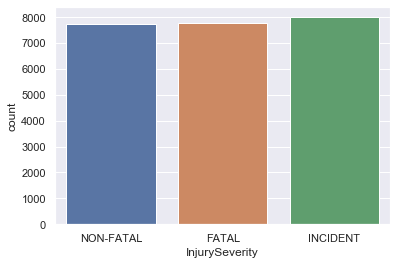

In [143]:
sb.countplot(b_train["InjurySeverity"])

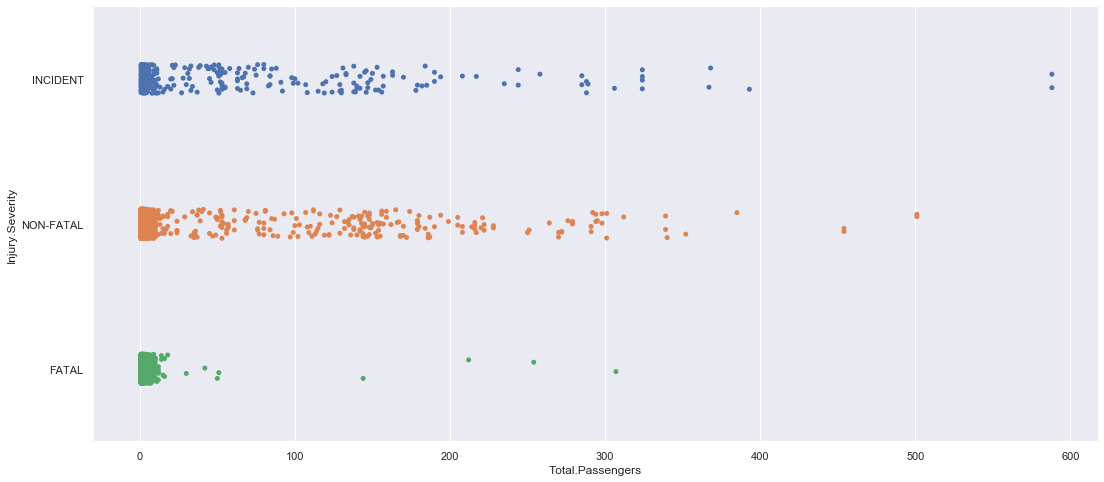

In [144]:
f, axes = plt.subplots(figsize=(18, 8))
sb.stripplot(x = "Total.Passengers", y = "Injury.Severity", data = aviationData, orient = "h")

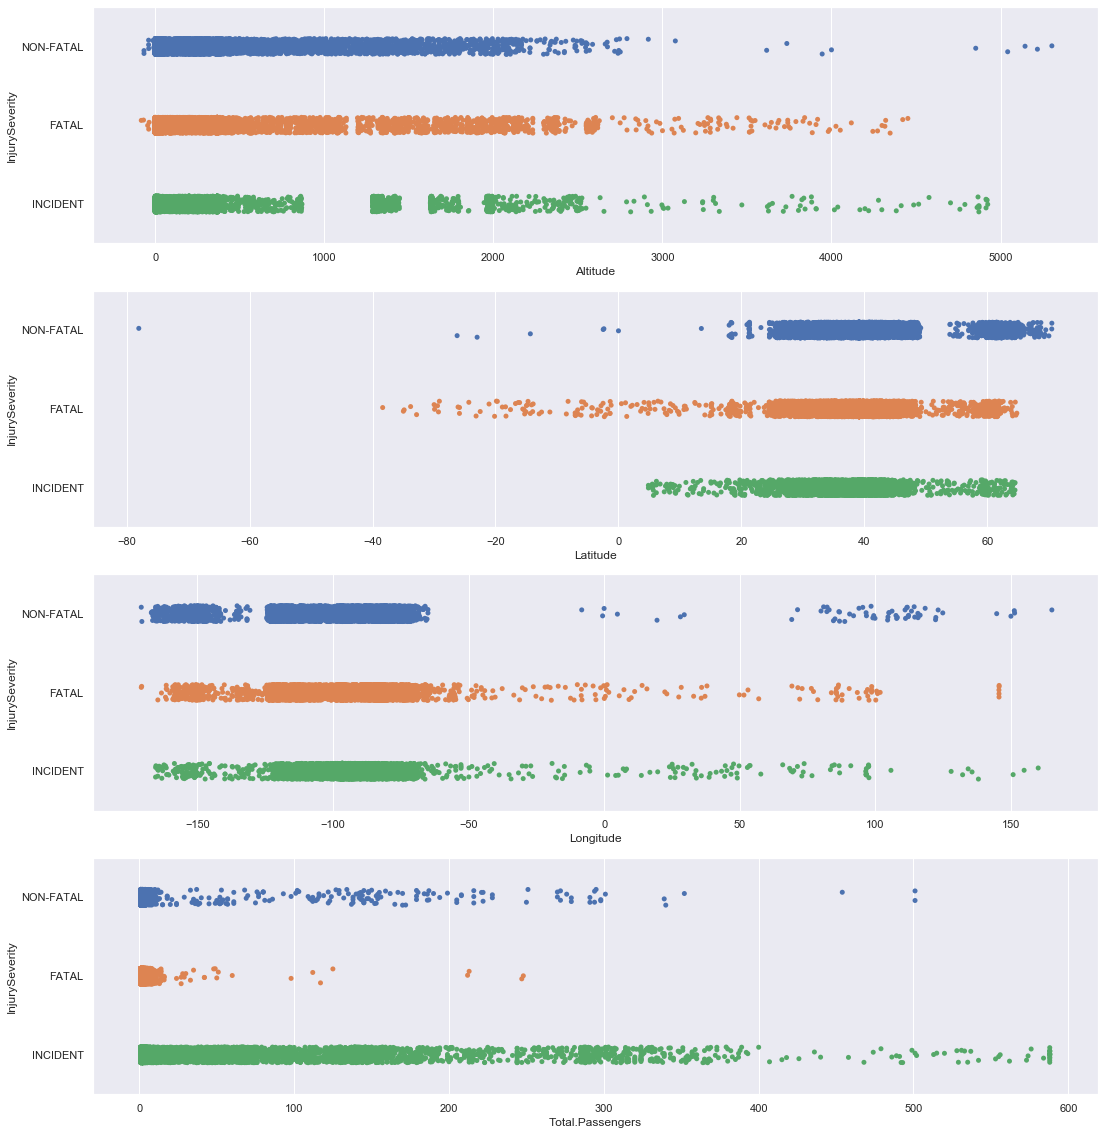

In [145]:
# Relationship between Response and the Predictors
trainDF = pd.concat([b_train, a_train.reindex(index=b_train.index)], sort = False, axis = 1)

f, axes = plt.subplots(4, 1, figsize=(18, 20))

count = 0
for var in a_train:
    if(var == 'Weather.Condition'):
        continue
    sb.stripplot(x = var, y = "InjurySeverity", data = trainDF, orient = "h", ax = axes[count])
    count += 1

In [146]:
dectree = DecisionTreeClassifier(max_depth = 4)  
dectree.fit(a_train, b_train)                    

b_train_pred = dectree.predict(a_train)
b_test_pred = dectree.predict(a_test)

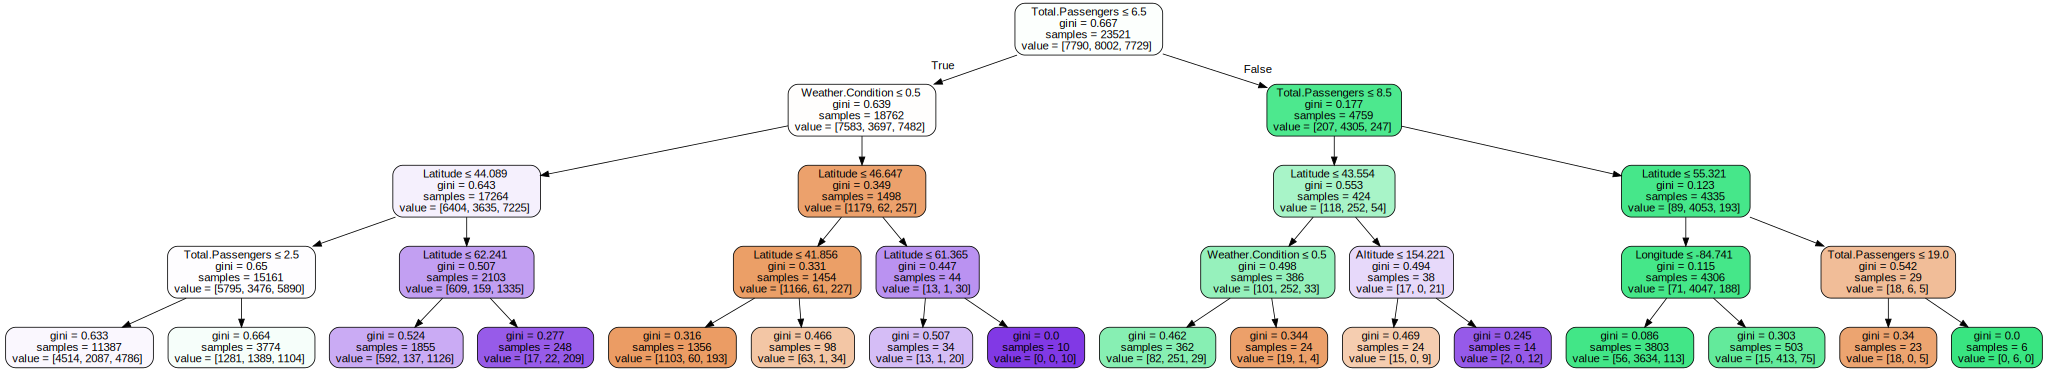

In [147]:
# Plot the Decision Tree
treedot = export_graphviz(dectree,                                  
                          feature_names = a_train.columns,          
                          out_file = None,                          
                          filled = True,                    
                          rounded = True,               
                          special_characters = True)                    

graphviz.Source(treedot)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.5558437141278006

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6946990833001195



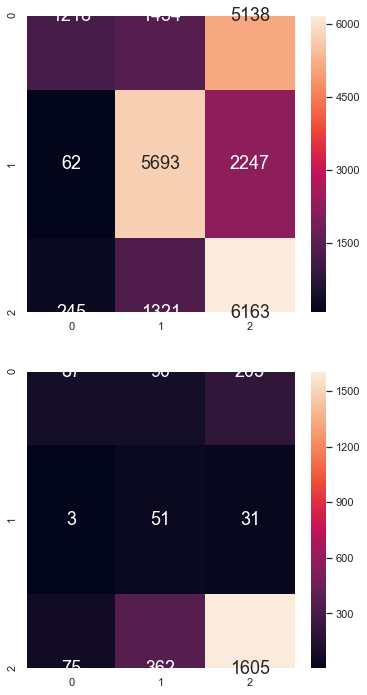

In [148]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(a_train, b_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(a_test, b_test))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(2, 1, figsize=(6, 12))
sb.heatmap(confusion_matrix(b_train, b_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(b_test, b_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [149]:
#Boosting the base tree with AdaBoost
AdaBoost = AdaBoostClassifier(base_estimator = dectree,
                              n_estimators = 125, learning_rate = 0.05)
boostModel = AdaBoost.fit(a_train,b_train)

pred = boostModel.predict(a_train)
predictions = metrics.accuracy_score(b_train,pred)
print("prediction accuracy of the train set is: ",predictions*100,"%")

pred = boostModel.predict(a_test)
predictions = metrics.accuracy_score(b_test,pred)
print("prediction accuracy of the test set is: ",predictions*100,"%")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


prediction accuracy of the train set is:  63.21159814633731 %
prediction accuracy of the test set is:  70.10761259465923 %
